In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import unicodedata

#### Funciones

In [2]:
# Función para eliminar acentos
def eliminar_acentos(texto):
    if isinstance(texto, str):
        texto = unicodedata.normalize('NFKD', texto)
        texto = ''.join([c for c in texto if not unicodedata.combining(c)])
    return texto

In [9]:
def get_median_df_byLOCATIONNAME(feature, df):
    median_feature = df.groupby('barrio')[feature].median()
    df_median_feature = median_feature.reset_index()
    df_median_feature.columns = ['NOMBRE', f"{feature}"]
    return df_median_feature

#### Carga de ficheros

url = 'https://raw.githubusercontent.com/JimenaAreta/thevalley-MDS/refs/heads/jimena/datasets/sample-flats-madrid-synthetic-coords.csv'  
df = pd.read_csv(url)

In [3]:
zip_path = './data/Barrios.zip'
gdf = gpd.read_file(f"zip://{zip_path}")

In [5]:
df_flats = pd.read_excel('./data/sample-flats-madrid-synthetic-coords.xlsx', engine = 'openpyxl')

In [ ]:
df_flats.to_csv('sample-flats-madrid-synthetic-coords.csv')

#### Transformación fichero flats

In [7]:
gdf['NOMBRE'] = gdf['NOMBRE'].str.lower().apply(eliminar_acentos)

In [8]:
df_flats['barrio'] = df_flats['barrio'].str.lower().apply(eliminar_acentos)

#### Generamos datos agrupados.

##### mediana de precio por barrios

In [8]:
df_flats.columns

Index(['CODE', 'LOCATIONNAME', 'barrio', 'PRICE', 'AREA', 'ROOMNUMBER',
       'BATHNUMBER', 'STATUS', 'STUDIO', 'ISPENTHOUSE', 'DUPLEX',
       'SWIMMINGPOOL', 'ELEVATOR', 'X', 'Y'],
      dtype='object')

In [7]:
df_flats.head()

,CODE,LOCATIONNAME,barrio,PRICE,AREA,ROOMNUMBER,BATHNUMBER,STATUS,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,X,Y
0,6606863734075793408,El Viso,el viso,1869000,290,4,3,Second hand / Good state,0,1,1,0,1,441543,4478087
1,9223372036854775808,Adelfas,adelfas,317000,75,2,1,Second hand / Good state,0,0,0,0,1,442956,4472317
2,9223372036854775808,Rosas,rosas,292000,90,2,2,Second hand / Good state,0,0,0,1,1,448837,4475183
3,6074027706670132224,Palomeras Bajas,palomeras bajas,95000,75,3,1,Second hand / Good state,0,0,0,0,0,444520,4470756
4,9223372036854775808,San Diego,san diego,86000,90,0,1,Second hand / Needs reformation,0,0,0,0,0,443178,4470744


In [10]:
median_price_byLocationame = get_median_df_byLOCATIONNAME('PRICE', df_flats)

In [11]:
# Realizar el cruce usando la columna 'NOMBRE'
gdf = gdf.merge(median_price_byLocationame, on='NOMBRE', how='left')

##### mediana de numero de habitaciones por barrios.

In [13]:
median_price_byLocationame = get_median_df_byLOCATIONNAME('ROOMNUMBER', df_flats)

In [14]:
# Realizar el cruce usando la columna 'NOMBRE'
gdf = gdf.merge(median_price_byLocationame, on='NOMBRE', how='left')

In [4]:
gdf.columns

Index(['Shape_Leng', 'Shape_Area', 'CODDIS', 'COD_DIS_TX', 'NOMDIS', 'COD_BAR',
       'COD_DISBAR', 'COD_DISB', 'NUM_BAR', 'NOMBRE', 'BARRIO_MAY',
       'BARRIO_MT', 'FCH_ALTA', 'FCH_BAJA', 'OBSERVACIO', 'APROBACION',
       'geometry'],
      dtype='object')

#### Representación gráfica.

##### representación por mathplotlib

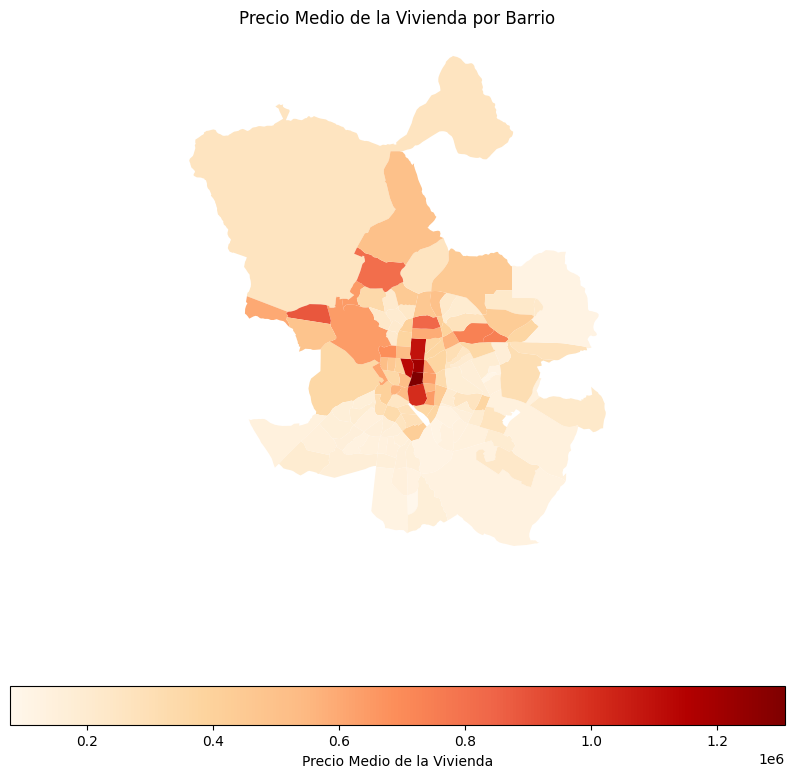

In [15]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='PRICE', ax=ax, legend=True, cmap='OrRd', legend_kwds={'label': "Precio Medio de la Vivienda",
                                                                              'orientation': "horizontal"})

# Añadir título y etiquetas
ax.set_title('Precio Medio de la Vivienda por Barrio')
ax.set_axis_off()

# Mostrar el mapa
plt.show()

##### representación por folium

In [30]:
def mostrar_menu():
    print("Elige una opción:")
    print("1. mediana de Precios/Barrio")
    print("2. mediana de NºHabitaciones/Barrio")
    opcion = input("Introduce el número de tu elección: ")
    return opcion

In [31]:
# Definimos las dos listas de elementos
lista_opcion_1 = ['NOMBRE', 'PRICE']
lista_opcion_2 = ['NOMBRE', 'ROOMNUMBER']

In [32]:
from pyproj import CRS
# Verificar el sistema de coordenadas actual
print(gdf.crs)

EPSG:4326


In [33]:
# Convertir el GeoDataFrame al sistema de coordenadas geográficas (WGS84)
gdf = gdf.to_crs(epsg=4326)

# Verificar el sistema de coordenadas después de la conversión
print(gdf.crs)

# Convertir el GeoDataFrame a JSON
gdf_json = gdf.to_json()

# Obtener el centro del mapa (puedes ajustar esto según sea necesario)
centroide = gdf.geometry.centroid
latitud = centroide.y.mean()  # Promedio de las latitudes
longitud = centroide.x.mean()  # Promedio de las longitudes

EPSG:4326


/tmp/ipykernel_2770/2688262453.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroide = gdf.geometry.centroid


In [34]:
import folium
import json

# Convertir el GeoDataFrame a JSON
gdf_json = gdf.to_json()

centroide = gdf.geometry.centroid
latitud = centroide.y.mean()  # Promedio de las latitudes
longitud = centroide.x.mean()  # Promedio de las longitudes

print(latitud, longitud)

# Crear un mapa centrado en la ubicación de tu ciudad
m = folium.Map(location=[latitud, longitud], zoom_start=12)  # Cambia latitud y longitud por las coordenadas de tu ciudad

40.42383073615918 -3.6801065932611787


/tmp/ipykernel_2770/3750031004.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroide = gdf.geometry.centroid


In [35]:
opcion = mostrar_menu()
if opcion == '1':
    print("Has elegido precio medio / barrio:")
    lista = lista_opcion_1
elif opcion == '2':
    print("Has elegido nº hab. medio / barrio:")
    lista = lista_opcion_2
else:
    print("Opción no válida. Por favor, elige 1 o 2.")

Elige una opción:
1. mediana de Precios/Barrio
2. mediana de NºHabitaciones/Barrio


Introduce el número de tu elección:  2


Has elegido nº hab. medio / barrio:


In [36]:
# Añadir los polígonos de los barrios al mapa
folium.Choropleth(
    geo_data=gdf_json,
    name='choropleth',
    data=gdf,
    columns=lista,  # Cambia 'nombre_barrio' por el nombre de la columna que identifica los barrios
    key_on='feature.properties.NOMBRE',  # Cambia 'nombre_barrio' por el nombre de la columna que identifica los barrios
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name=f'{lista[1]} medio por barrio'
).add_to(m)

# Añadir control de capas
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save('mapa_precio_medio_vivienda.html')

# Mostrar el mapa en un notebook (opcional)
m